<a href="https://colab.research.google.com/github/NatBrian/wildlife-camera-trap-ai-system/blob/main/notebook/wildlife_yolov8_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Introduction & Objectives

Camera traps are motion- or heat-triggered cameras placed in the wild that capture images whenever something moves through the scene. They produce huge numbers of images, many of which are empty; the valuable ones contain animals (sometimes multiple species at once). Object detection models add bounding boxes and class labels to each animal instance, which is more informative than image-level classification: you can count individuals, know where they are, and trigger actions only when animals appear.

YOLOv8 is a modern one-stage detector that is fast, compact, and friendly to edge devices. In this notebook you'll build an end-to-end pipeline for a real camera-trap detection dataset (ENA24: Eastern North America) that includes bounding boxes and species labels. You'll learn **what** happens at every step and **why** it matters, from data cleaning through training, evaluation, and exporting models for lightweight edge deployments (e.g., a Raspberry Pi or Jetson that records clips only when wildlife is detected).

**What we'll do**
- Set up a Colab GPU environment with YOLOv8.
- Download and explore a wildlife detection dataset with bounding boxes.
- Clean annotations, convert COCO → YOLO format, and make a train/val split.
- Train a small YOLOv8 model (transfer learning from COCO weights) suitable for Colab Free.
- Evaluate with metrics (mAP, precision, recall) and visual inspection.
- Run inference on sample images, including empty frames.
- Export to ONNX/TorchScript for edge-device deployment.

Throughout, you'll see why each step exists (e.g., cleaning boxes to avoid bad labels) and how it connects to an edge workflow that saves video clips only when animals enter the frame.

## 2. Setup and Dependencies

- Colab GPUs (T4/P100) dramatically speed up training vs CPU.
- YOLOv8 is chosen because it offers small, fast variants (\`yolov8n\`, \`yolov8s\`) that run well on edge hardware while keeping accuracy competitive.
- We'll install only the essentials: YOLOv8 (\`ultralytics\`), Torch, COCO helpers, and plotting utilities.

In [1]:
# Check hardware and install dependencies
import subprocess, sys

gpu_info = subprocess.run("nvidia-smi -L", shell=True, capture_output=True, text=True)
if gpu_info.returncode == 0 and gpu_info.stdout.strip():
    print("GPU detected:\n", gpu_info.stdout)
else:
    print("No GPU detected. Switch Colab to a GPU runtime for much faster training.")

packages = [
    "ultralytics==8.1.34",  # YOLOv8
    "opencv-python",
    "matplotlib",
    "seaborn",
    "pyyaml",
    "pycocotools",
    "pandas",
    "requests"
]
print("Installing packages ... this takes ~1 minute on Colab")
subprocess.run(f"pip install -q {' '.join(packages)}", shell=True, check=True)
print("Done.")


GPU detected:
 GPU 0: Tesla T4 (UUID: GPU-f73c1300-26e1-a3cb-5a9f-32d754d8c5ff)

Installing packages ... this takes ~1 minute on Colab
Done.


In [2]:
# Imports, paths, and basic config
import json, random, shutil, zipfile, tarfile, os
from pathlib import Path
from collections import defaultdict, Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import yaml
from IPython.display import Image, display
from ultralytics import YOLO

sns.set_style("whitegrid")
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Base working folders (Colab uses /content by default)
BASE_DIR = Path("/content/wildlife_yolov8")
DATA_ROOT = BASE_DIR / "data"
RAW_DIR = DATA_ROOT / "raw"
PROC_DIR = DATA_ROOT / "processed"
YOLO_DIR = DATA_ROOT / "wildlife_yolo"
for d in [BASE_DIR, DATA_ROOT, RAW_DIR, PROC_DIR, YOLO_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data root: {DATA_ROOT}")
print(f"CUDA available: {torch.cuda.is_available()}")


Base directory: /content/wildlife_yolov8
Data root: /content/wildlife_yolov8/data
CUDA available: True


## 3. Downloading and Exploring the Dataset

We use **ENA24** (Eastern North America) with COCO-style annotations. Two download options:
- **Full zip**: grabs the entire dataset (~1–2 GB). Good if you want everything offline.
- **Lightweight subset (metadata-driven)**: pulls the COCO JSON and only downloads a manageable number of annotated images (e.g., 500–1200) via HTTP. This is faster on Colab Free and mirrors the Gemini notebook's speed-focused approach.

Camera-trap quirks to remember: many empty frames, night IR lighting, class imbalance, and occasional bad boxes. We'll clean and filter in later steps.

In [3]:
# Download or locate the ENA24 detection dataset (COCO-style)
import subprocess, requests, shutil

# Choose download mode: "full_zip" (all data) or "subset" (faster, downloads only N annotated images)
DOWNLOAD_MODE = "full_zip"  # options: "subset" or "full_zip"
NUM_IMAGES_TO_DOWNLOAD = 800  # used only in subset mode; adjust for speed/coverage
# Force a re-download in full_zip mode even if the folder is non-empty (useful if a prior subset run left partial data)
FORCE_FULL_DOWNLOAD = False # Set to True to ensure a fresh download and extraction

# Drive toggle if you already have the data there
USE_DRIVE = False

RAW_EXTRACT_DIR = RAW_DIR / "ena24"
# Define explicit paths for images based on expected extraction structure
# Corrected based on observed zip extraction: zip extracts 'ena24/images' into RAW_EXTRACT_DIR
FULL_IMAGES_ROOT = RAW_EXTRACT_DIR
SUBSET_IMAGES_ROOT = RAW_EXTRACT_DIR / "images_subset"

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    # If using Drive, adjust RAW_EXTRACT_DIR and IMAGE_ROOTs accordingly
    RAW_EXTRACT_DIR = Path('/content/drive/MyDrive/ena24_detection')
    FULL_IMAGES_ROOT = RAW_EXTRACT_DIR / "ena24" # Corrected for Drive path as well
    SUBSET_IMAGES_ROOT = RAW_EXTRACT_DIR / "images_subset"

RAW_EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

# Updated metadata and image URLs (with fallbacks across GCP/Azure/AWS)
METADATA_URLS = [
    "https://lilawildlife.blob.core.windows.net/lila-wildlife/ena24/ena24.json",
    "https://storage.googleapis.com/public-datasets-lila/ena24/ena24.json",
    "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/ena24/ena24.json",
]
IMAGE_ZIP_URLS = [
    "https://storage.googleapis.com/public-datasets-lila/ena24/ena24.zip",
    "https://lilawildlife.blob.core.windows.net/lila-wildlife/ena24/ena24.zip",
    "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/ena24/ena24.zip",
]
# Base URL list for per-image downloads in subset mode
IMAGE_BASE_URLS = [
    "https://lilawildlife.blob.core.windows.net/lila-wildlife/ena24/",
    "https://storage.googleapis.com/public-datasets-lila/ena24/",
    "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/ena24/",
]

METADATA_PATH = RAW_EXTRACT_DIR / "ena24_metadata.json"
ZIP_PATH = RAW_DIR / "ena24_detection.zip"


def smart_extract(archive_path: Path, dest: Path):
    """Extract .zip or .tar.gz archives to dest."""
    if archive_path.suffix == '.zip' and zipfile.is_zipfile(archive_path):
        with zipfile.ZipFile(archive_path, 'r') as zf:
            zf.extractall(dest)
    elif archive_path.suffixes[-2:] == ['.tar', '.gz']:
        with tarfile.open(archive_path, 'r:gz') as tf:
            tf.extractall(dest)
    else:
        raise ValueError(f"Unsupported archive type: {archive_path}")


def download_with_fallback(urls, dest):
    for url in urls:
        print(f"Trying {url} ...")
        result = subprocess.run(f"wget -O {dest} {url}", shell=True)
        if result.returncode == 0:
            print(f"Success: {url}")
            return url
    raise RuntimeError("All download URLs failed. Please update the URL list or mount the data from Drive.")


if DOWNLOAD_MODE == "full_zip":
    # If forcing a full download, clean up any previous state
    if FORCE_FULL_DOWNLOAD:
        print(f"FORCE_FULL_DOWNLOAD=True -> Cleaning up {RAW_EXTRACT_DIR} before re-download.")
        if RAW_EXTRACT_DIR.exists():
            shutil.rmtree(RAW_EXTRACT_DIR)
        RAW_EXTRACT_DIR.mkdir(parents=True, exist_ok=True)

    # Check if images already exist at the expected full path and are non-empty
    has_full_images = FULL_IMAGES_ROOT.exists() and len(list(FULL_IMAGES_ROOT.rglob("*.jpg"))) > 0

    if FORCE_FULL_DOWNLOAD or not has_full_images:
        if not ZIP_PATH.exists() or FORCE_FULL_DOWNLOAD:
            print("Downloading ENA24 full zip with fallbacks...")
            download_with_fallback(IMAGE_ZIP_URLS, ZIP_PATH)
        print(f"Extracting dataset to {RAW_EXTRACT_DIR} ...")
        smart_extract(ZIP_PATH, RAW_EXTRACT_DIR)

        # After extraction, verify FULL_IMAGES_ROOT and set IMAGES_ROOT
        if not FULL_IMAGES_ROOT.exists():
             raise FileNotFoundError(f"Full images directory not found at {FULL_IMAGES_ROOT} after extraction. "
                                     "Verify zip structure or extraction path.")
    else:
        print("Full dataset already present, skipping download/extract.")

    IMAGES_ROOT = FULL_IMAGES_ROOT

    # Locate annotation file for full_zip mode, typically directly under RAW_EXTRACT_DIR or within ena24 folder
    # Adjusted to look for json directly within RAW_EXTRACT_DIR, as the extracted `ena24` folder likely holds images, not json.
    # The JSON is typically directly in the downloaded zip root or a fixed path known to the metadata URL.
    # If the JSON is *also* nested within the 'ena24' folder created by extraction, this path needs adjustment.
    # For ENA24, the .json is likely at the top level of the extracted contents, i.e., RAW_EXTRACT_DIR / 'ena24_metadata.json' or 'ena24.json'
    # Given the previous error, let's assume the metadata is found more directly.
    # We'll stick to METADATA_PATH as defined initially, which is RAW_EXTRACT_DIR / "ena24_metadata.json"

    if not METADATA_PATH.exists():
        print("Downloading metadata JSON (fallbacks)...")
        success = False
        for url in METADATA_URLS:
            try:
                resp = requests.get(url, timeout=30)
                resp.raise_for_status()
                METADATA_PATH.write_bytes(resp.content)
                print("Metadata saved to", METADATA_PATH)
                success = True
                break
            except Exception as e:
                print(f"Failed metadata URL {url}: {e}")
        if not success:
            raise RuntimeError("All metadata URLs failed. Update METADATA_URLS or mount the file from Drive.")
    else:
        print("Metadata already present.")
    ANNOTATION_PATH = METADATA_PATH

else:  # subset mode: download metadata + only N annotated images
    IMAGES_ROOT = SUBSET_IMAGES_ROOT
    IMAGES_ROOT.mkdir(parents=True, exist_ok=True) # Ensure subset dir exists before downloads

    if not METADATA_PATH.exists():
        print("Downloading metadata JSON (fallbacks)...")
        success = False
        for url in METADATA_URLS:
            try:
                resp = requests.get(url, timeout=30)
                resp.raise_for_status()
                METADATA_PATH.write_bytes(resp.content)
                print("Metadata saved to", METADATA_PATH)
                success = True
                break
            except Exception as e:
                print(f"Failed metadata URL {url}: {e}")
        if not success:
            raise RuntimeError("All metadata URLs failed. Update METADATA_URLS or mount the file from Drive.")
    else:
        print("Metadata already present.")

    with open(METADATA_PATH, 'r') as f:
        meta_coco = json.load(f)

    annotated_image_ids = set(ann['image_id'] for ann in meta_coco['annotations'])
    valid_images = [img for img in meta_coco['images'] if img['id'] in annotated_image_ids]
    random.shuffle(valid_images)
    subset = valid_images[:min(NUM_IMAGES_TO_DOWNLOAD, len(valid_images))]
    print(f"Downloading {len(subset)} annotated images (subset mode)...")

    downloaded_images = []
    for img in subset:
        if len(downloaded_images) >= NUM_IMAGES_TO_DOWNLOAD:
            break
        rel_path = Path(img['file_name'])
        dest_path = IMAGES_ROOT / rel_path.name # Use rel_path.name to avoid nested folders in subset
        dest_path.parent.mkdir(parents=True, exist_ok=True)
        if dest_path.exists():
            downloaded_images.append(img)
            continue
        downloaded = False
        tried = set()
        for base in IMAGE_BASE_URLS:
            # try with full relative path and just the basename as some hosts differ
            for candidate in [f"{base}{img['file_name']}", f"{base}{rel_path.name}"]:
                if candidate in tried:
                    continue
                tried.add(candidate)
                try:
                    r = requests.get(candidate, stream=True, timeout=30)
                    if r.status_code == 200:
                        with open(dest_path, 'wb') as f_out:
                            f_out.write(r.content)
                        downloaded = True
                        downloaded_images.append(img)
                        break
                except Exception as e:
                    print(f"Failed {candidate}: {e}")
            if downloaded:
                break
        if not downloaded:
            print(f"Failed to download image {img['file_name']} from all bases.")

    print(f"Downloaded {len(downloaded_images)} / {len(subset)} requested images.")
    ANNOTATION_PATH = METADATA_PATH

print(f"Using images from: {IMAGES_ROOT}")
print(f"Using annotations: {ANNOTATION_PATH}")

Trying https://storage.googleapis.com/public-datasets-lila/ena24/ena24.zip ...
Success: https://storage.googleapis.com/public-datasets-lila/ena24/ena24.zip
Extracting dataset to /content/wildlife_yolov8/data/raw/ena24 ...
Metadata saved to /content/wildlife_yolov8/data/raw/ena24/ena24_metadata.json
Using images from: /content/wildlife_yolov8/data/raw/ena24
Using annotations: /content/wildlife_yolov8/data/raw/ena24/ena24_metadata.json


Images listed in COCO: 9676
Annotations: 11596
Categories: 23
Sample categories: ['Bird', 'Eastern Gray Squirrel', 'Eastern Chipmunk', 'Woodchuck', 'Wild Turkey', 'White_Tailed_Deer', 'Virginia Opossum', 'Eastern Cottontail', 'Human', 'Vehicle']


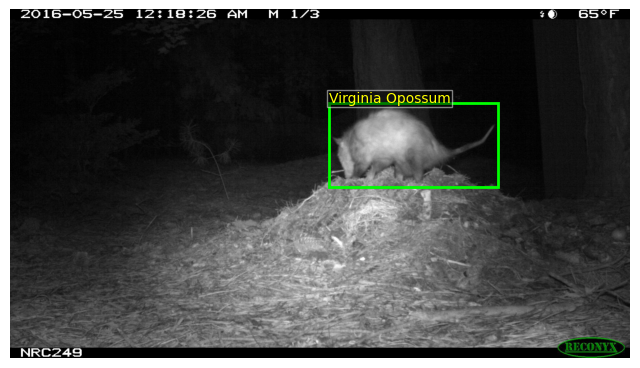

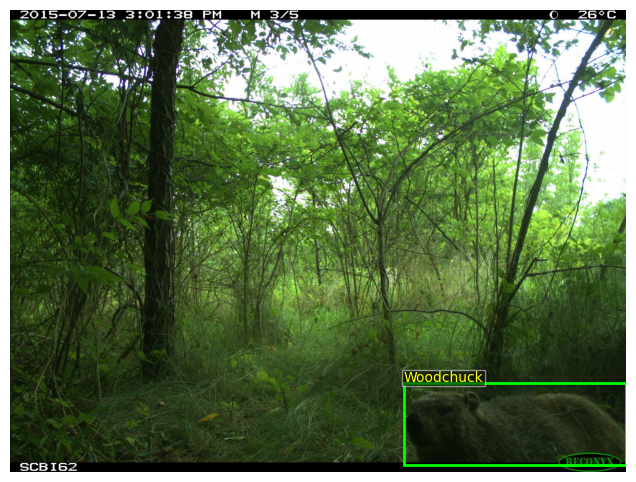

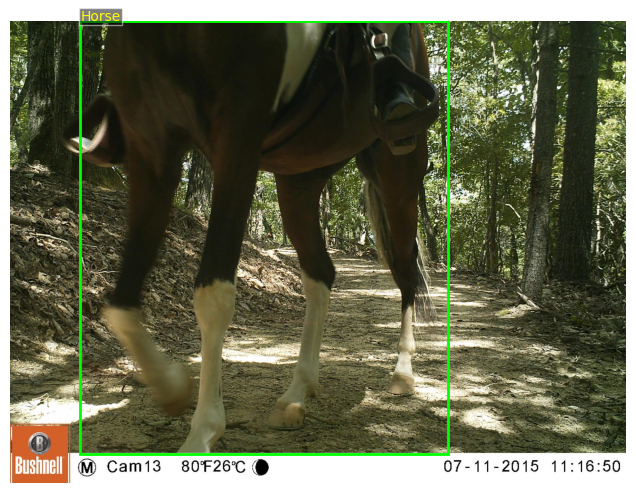

In [4]:
# Explore the raw data: inspect COCO structure and visualize a few examples

with open(ANNOTATION_PATH, 'r') as f:
    coco = json.load(f)

print(f"Images listed in COCO: {len(coco['images'])}")
print(f"Annotations: {len(coco['annotations'])}")
print(f"Categories: {len(coco['categories'])}")

category_id_to_name = {c['id']: c['name'] for c in coco['categories']}
print("Sample categories:", list(category_id_to_name.values())[:10])

def resolve_image_path(file_name: str) -> Path:
    """Best-effort resolver for file paths regardless of stored prefix/case/extension."""
    direct = IMAGES_ROOT / file_name
    if direct.exists():
        return direct
    base = IMAGES_ROOT / Path(file_name).name
    if base.exists():
        return base
    # Try common extension/case variants
    stem = Path(file_name).stem
    for ext in [".jpg", ".JPG", ".jpeg", ".JPEG", ".png", ".PNG"]:
        cand = IMAGES_ROOT / f"{stem}{ext}"
        if cand.exists():
            return cand
    # Last resort: search for a matching basename anywhere under IMAGES_ROOT
    matches = list(IMAGES_ROOT.rglob(Path(file_name).name))
    if matches:
        return matches[0]
    return direct  # fallback (even if missing)

def draw_coco_example(image_meta, annotations):
    """Load one image and draw its bounding boxes with labels."""
    img_path = resolve_image_path(image_meta['file_name'])
    if not img_path.exists():
        print(f"Missing image: {img_path}")
        return
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(img)
    ax.axis('off')
    for ann in annotations:
        x, y, w, h = ann['bbox']
        rect = plt.Rectangle((x, y), w, h, fill=False, color='lime', linewidth=2)
        ax.add_patch(rect)
        label = category_id_to_name.get(ann['category_id'], 'unknown')
        ax.text(x, y - 2, label, color='yellow', fontsize=10, bbox=dict(facecolor='black', alpha=0.5, pad=1))
    plt.show()

# Pick a few images that actually have annotations (skip empty frames)
ann_by_image = defaultdict(list)
for ann in coco['annotations']:
    ann_by_image[ann['image_id']].append(ann)

# Only keep images with at least one annotation
image_with_boxes = [img for img in coco['images'] if len(ann_by_image[img['id']]) > 0]
for sample in random.sample(image_with_boxes, min(3, len(image_with_boxes))):
    draw_coco_example(sample, ann_by_image[sample['id']])


## 4. Cleaning and Transforming the Data

Why clean?
- Broken images or impossible bounding boxes (negative sizes) harm training.
- Camera traps have many empty frames and long-tail classes; we'll keep the top-N most frequent species and optionally cap the number of images to stay within Colab Free limits.
- YOLO needs one text file per image (\`class_id x_center y_center width height\`, normalized 0–1). We'll convert from COCO's pixel-space format.

Controls in the next cell:
- \`TOP_K_CLASSES\`: keep the most common classes.
- \`MAX_IMAGES\`: limit total images for a quick run.
- \`MIN_BOX_AREA\`: drop tiny or zero-area boxes.

In [5]:
# Clean annotations and convert COCO → YOLO format
TOP_K_CLASSES = 6         # keep the most common classes
MAX_IMAGES = 1200         # None for full data, but 1.2k keeps Colab runs reasonable
MIN_BOX_AREA = 16         # drop boxes that are too small to be reliable

image_id_to_meta = {img['id']: img for img in coco['images']}
ann_by_image = defaultdict(list)
for ann in coco['annotations']:
    ann_by_image[ann['image_id']].append(ann)

# Remove invalid boxes and collect basic stats
valid_annotations = []
for ann in coco['annotations']:
    img_meta = image_id_to_meta.get(ann['image_id'])
    if img_meta is None:
        continue
    x, y, w, h = ann['bbox']
    if w <= 0 or h <= 0 or w * h < MIN_BOX_AREA:
        continue
    valid_annotations.append(ann)

existing_files = {p.name for p in IMAGES_ROOT.rglob('*') if p.suffix.lower() in ('.jpg', '.jpeg', '.png')}

def image_exists(file_name: str) -> bool:
    path = resolve_image_path(file_name)
    if path.exists():
        return True
    return Path(file_name).name in existing_files

present_class_counts = Counter([
    a['category_id']
    for a in valid_annotations
    if image_exists(image_id_to_meta[a['image_id']]['file_name'])
])
keep_categories = [cid for cid, _ in present_class_counts.most_common(TOP_K_CLASSES)]
print("Top classes (after presence check):")
for cid in keep_categories:
    print(f"  {cid}: {category_id_to_name[cid]} (count={present_class_counts[cid]})")

if not keep_categories:
    # Fallback to overall counts (ignoring existence) to avoid empty selection
    print("Warning: no categories survived the existence check; falling back to global class counts.")
    overall_counts = Counter([a['category_id'] for a in valid_annotations])
    keep_categories = [cid for cid, _ in overall_counts.most_common(TOP_K_CLASSES)]
    if not keep_categories:
        raise ValueError('No categories found at all. Check download integrity or paths.')

filtered_annotations = [
    a for a in valid_annotations
    if a['category_id'] in keep_categories
    and image_exists(image_id_to_meta[a['image_id']]['file_name'])
]
if not filtered_annotations:
    raise ValueError('No annotations matched existing images. Check paths/extensions or re-download the dataset.')
images_with_kept_classes = sorted({a['image_id'] for a in filtered_annotations})

# Keep only those whose image files actually exist (important in subset mode)
existing_images = []
for img_id in images_with_kept_classes:
    meta = image_id_to_meta[img_id]
    if image_exists(meta['file_name']):
        existing_images.append(img_id)

if not existing_images:
    raise ValueError("No images found on disk after filtering. Check download mode or paths.")
    existing_images.append(img_id)

if MAX_IMAGES is not None:
    random.shuffle(existing_images)
    existing_images = existing_images[:MAX_IMAGES]
print(f"Images kept after filtering & existence check: {len(existing_images)}")

# Remap category IDs to 0..N-1 in a stable order
sorted_cats = sorted(keep_categories)
cat_id_to_yolo = {cid: idx for idx, cid in enumerate(sorted_cats)}
class_names = [category_id_to_name[cid] for cid in sorted_cats]

labels_dir = PROC_DIR / "labels"
images_dir = PROC_DIR / "images"
labels_dir.mkdir(parents=True, exist_ok=True)
images_dir.mkdir(parents=True, exist_ok=True)

converted = []  # list of {image_path, label_path}
skipped_missing = 0

for img_id in existing_images:
    meta = image_id_to_meta[img_id]
    src_img_path = resolve_image_path(meta['file_name'])
    if not src_img_path.exists():
        skipped_missing += 1
        continue
    stem = Path(meta['file_name']).stem
    ext = Path(meta['file_name']).suffix or '.jpg'
    dst_img_path = images_dir / f"{stem}{ext}"
    dst_label_path = labels_dir / f"{stem}.txt"

    # Copy image into the processed folder (small subset keeps storage reasonable)
    if not dst_img_path.exists():
        shutil.copy2(src_img_path, dst_img_path)

    lines = []
    for ann in ann_by_image[img_id]:
        if ann['category_id'] not in keep_categories:
            continue
        x, y, w, h = ann['bbox']
        x_c = (x + w / 2) / meta['width']
        y_c = (y + h / 2) / meta['height']
        w_n = w / meta['width']
        h_n = h / meta['height']
        # Clamp to [0,1] to avoid edge numeric issues
        x_c = min(max(x_c, 0.0), 1.0)
        y_c = min(max(y_c, 0.0), 1.0)
        w_n = min(max(w_n, 0.0), 1.0)
        h_n = min(max(h_n, 0.0), 1.0)
        cls = cat_id_to_yolo[ann['category_id']]
        lines.append(f"{cls} {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")

    if lines:
        with open(dst_label_path, 'w') as f:
            f.write("\n".join(lines))
        converted.append({"image_path": dst_img_path, "label_path": dst_label_path})

if not converted:
    raise ValueError('No images were converted. Check download mode, paths, or filtering settings.')
print(f"Converted {len(converted)} images. Missing images skipped: {skipped_missing}")
print(f"Class names (YOLO order): {class_names}")


Top classes (after presence check):
  17: American Crow (count=1278)
  22: American Black Bear (count=959)
  18: Chicken (count=732)
  16: Dog (count=726)
  6: Virginia Opossum (count=725)
  19: Domestic Cat (count=482)
Images kept after filtering & existence check: 1200
Converted 1200 images. Missing images skipped: 0
Class names (YOLO order): ['Virginia Opossum', 'Dog', 'American Crow', 'Chicken', 'Domestic Cat', 'American Black Bear']


## 5. Preparing YOLOv8 Dataset Structure

YOLO expects:
```
data/wildlife_yolo/
  images/train, images/val
  labels/train, labels/val  (same filenames, .txt)
wildlife.yaml  (paths + class names)
```
- We'll split train/val (80/20), copy files into the YOLO layout, and write a YAML config.
- The order of \`names\` in the YAML **must** match the numeric class IDs we wrote.

In [6]:
# Create YOLO directory tree and train/val split
train_ratio = 0.8
random.shuffle(converted)
split_idx = int(len(converted) * train_ratio)
train_items = converted[:split_idx]
val_items = converted[split_idx:]
if len(val_items) == 0 and len(train_items) > 1:
    val_items.append(train_items.pop())  # ensure we have a val set for metrics
elif len(val_items) == 0:
    raise ValueError('Not enough images to create a validation split. Reduce filtering or MAX_IMAGES.')

for subset, items in [("train", train_items), ("val", val_items)]:
    (YOLO_DIR / "images" / subset).mkdir(parents=True, exist_ok=True)
    (YOLO_DIR / "labels" / subset).mkdir(parents=True, exist_ok=True)
    for entry in items:
        dst_img = YOLO_DIR / "images" / subset / entry['image_path'].name
        dst_lbl = YOLO_DIR / "labels" / subset / entry['label_path'].name
        if not dst_img.exists():
            shutil.copy2(entry['image_path'], dst_img)
        if not dst_lbl.exists():
            shutil.copy2(entry['label_path'], dst_lbl)

yaml_path = YOLO_DIR / "wildlife.yaml"
yaml_dict = {
    "path": str(YOLO_DIR),
    "train": "images/train",
    "val": "images/val",
    "names": class_names
}
with open(yaml_path, 'w') as f:
    yaml.safe_dump(yaml_dict, f)

print(f"Train images: {len(train_items)}, Val images: {len(val_items)}")
print(f"Wrote dataset YAML to: {yaml_path}")


Train images: 960, Val images: 240
Wrote dataset YAML to: /content/wildlife_yolov8/data/wildlife_yolo/wildlife.yaml


## 6. Training YOLOv8

Key ideas:
- **Transfer learning**: start from a COCO-pretrained checkpoint (\`yolov8n.pt\`) so we learn faster with fewer epochs.
- **Hyperparameters**:
  - \`epochs\`: passes over the data (20–40 is fine for this subset).
  - \`batch\`: images per step (increase until GPU memory complaints).
  - \`imgsz\`: resize dimension; 640 balances detail vs speed.
  - \`patience\`: early stopping if metrics stop improving.
- **Model size trade-off**: \`yolov8n\` (nano) is fastest/lightest; \`yolov8s\` is a bit slower but more accurate. We'll use nano for Colab Free.

In [8]:
import os
os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"

from pathlib import Path
from ultralytics import YOLO
import torch

batch_size = 16 if torch.cuda.is_available() else 4

# No need for add_safe_globals if we forced weights_only=False
model = YOLO('yolov8n.pt')  # should now load without the UnpicklingError

train_results = model.train(
    data=str(yaml_path),
    epochs=30,
    imgsz=640,
    batch=batch_size,
    patience=5,
    name='ena24_yolov8n',
    project='wildlife_yolov8', # str(BASE_DIR),
    pretrained=True,
)

print("Training complete. Best weights saved under:", Path(model.trainer.save_dir) / 'weights')

New https://pypi.org/project/ultralytics/8.3.232 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py:716: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")


engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/wildlife_yolov8/data/wildlife_yolo/wildlife.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=wildlife_yolov8, name=ena24_yolov8n2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=to

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: chieter (chieter-nan) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py:716: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")
/usr/local/lib/python3.12/dist-packages/ultralytics/utils/checks.py:641: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(True):


AMP: checks passed ✅


/usr/local/lib/python3.12/dist-packages/ultralytics/engine/trainer.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /content/wildlife_yolov8/data/wildlife_yolo/labels/train... 960 images, 0 backgrounds, 0 corrupt: 100%|██████████| 960/960 [00:00<00:00, 2388.70it/s]


train: New cache created: /content/wildlife_yolov8/data/wildlife_yolo/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:846: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
val: Scanning /content/wildlife_yolov8/data/wildlife_yolo/labels/val... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 1273.21it/s]


val: New cache created: /content/wildlife_yolov8/data/wildlife_yolo/labels/val.cache
Plotting labels to wildlife_yolov8/ena24_yolov8n2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to wildlife_yolov8/ena24_yolov8n2
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.29G      1.175      3.176      1.224         34        640: 100%|██████████| 60/60 [00:29<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]

                   all        240        269      0.858      0.155      0.444      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.24G      1.167      2.154      1.191         44        640: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.45it/s]


                   all        240        269      0.488      0.563      0.563      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.25G      1.201      1.959      1.201         30        640: 100%|██████████| 60/60 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.62it/s]

                   all        240        269       0.71       0.56       0.66      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.28G      1.199      1.785      1.214         35        640: 100%|██████████| 60/60 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.04it/s]

                   all        240        269      0.701      0.616      0.709       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.28G       1.18      1.686      1.216         33        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        240        269      0.632      0.598      0.628      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.29G      1.148      1.519      1.211         27        640: 100%|██████████| 60/60 [00:25<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.11it/s]

                   all        240        269      0.673      0.652       0.71      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30       2.3G      1.136      1.384      1.194         35        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]

                   all        240        269      0.806      0.704      0.792       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.31G      1.099      1.338      1.176         36        640: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.13it/s]

                   all        240        269       0.74       0.74      0.778      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.33G      1.095      1.294      1.163         32        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        240        269      0.753      0.761      0.792      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.34G      1.111      1.197      1.175         39        640: 100%|██████████| 60/60 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]

                   all        240        269      0.804      0.731      0.819      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.35G      1.048      1.114      1.146         27        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

                   all        240        269      0.829       0.69      0.804      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.36G      1.037      1.011      1.146         36        640: 100%|██████████| 60/60 [00:25<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.33it/s]

                   all        240        269      0.841       0.79      0.859       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.37G      1.019       0.98      1.119         45        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        240        269      0.857      0.809      0.874       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.39G     0.9933     0.9192      1.106         38        640: 100%|██████████| 60/60 [00:25<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.09it/s]

                   all        240        269      0.888       0.82      0.883      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30       2.4G      1.008     0.9021      1.129         33        640: 100%|██████████| 60/60 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.43it/s]

                   all        240        269      0.896      0.777      0.863      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.41G     0.9755     0.8412      1.108         26        640: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.29it/s]

                   all        240        269      0.913      0.797      0.892      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.42G     0.9588     0.8267      1.083         34        640: 100%|██████████| 60/60 [00:24<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]

                   all        240        269      0.896       0.82      0.903       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.44G      0.946     0.8192      1.093         43        640: 100%|██████████| 60/60 [00:26<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.23it/s]

                   all        240        269      0.892      0.832       0.89      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.45G     0.9327     0.7878      1.083         44        640: 100%|██████████| 60/60 [00:25<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.63it/s]

                   all        240        269      0.921       0.85      0.922      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.46G     0.9355     0.7755      1.094         38        640: 100%|██████████| 60/60 [00:25<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

                   all        240        269      0.919       0.85      0.915      0.647


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.12/dist-packages/ultralytics/data/augment.py:846: UserWarning: Argument(s) 'quality_lower' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=75, p=0.0),
/usr/local/lib/python3.12/dist-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.48G      0.902     0.7758      1.066         20        640: 100%|██████████| 60/60 [00:27<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.64it/s]


                   all        240        269      0.896       0.87      0.923      0.633

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.49G     0.8914     0.6823      1.057         19        640: 100%|██████████| 60/60 [00:25<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

                   all        240        269      0.916      0.817      0.928      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30       2.5G     0.8733     0.6657      1.048         21        640: 100%|██████████| 60/60 [00:25<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        240        269      0.862       0.87      0.915      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.51G     0.8448     0.6241      1.023         17        640: 100%|██████████| 60/60 [00:25<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.38it/s]

                   all        240        269      0.909      0.847      0.904      0.652
Stopping training early as no improvement observed in last 5 epochs. Best results observed at epoch 19, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



24 epochs completed in 0.212 hours.


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/torch_utils.py:485: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  x = torch.load(f, map_location=torch.device("cpu"))


Optimizer stripped from wildlife_yolov8/ena24_yolov8n2/weights/last.pt, 6.2MB
Optimizer stripped from wildlife_yolov8/ena24_yolov8n2/weights/best.pt, 6.2MB

Validating wildlife_yolov8/ena24_yolov8n2/weights/best.pt...
Ultralytics YOLOv8.1.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py:716: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")


Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.81it/s]


                   all        240        269      0.921       0.85      0.921      0.665
      Virginia Opossum        240         38      0.963      0.947      0.992      0.801
                   Dog        240         39      0.884      0.872       0.86      0.613
         American Crow        240         74      0.971      0.905      0.973       0.69
               Chicken        240         34       0.93       0.78      0.884      0.595
          Domestic Cat        240         31      0.904       0.71      0.872      0.565
   American Black Bear        240         53      0.877      0.887      0.949      0.723
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to wildlife_yolov8/ena24_yolov8n2


Training complete. Best weights saved under: wildlife_yolov8/ena24_yolov8n2/weights


/usr/local/lib/python3.12/dist-packages/ultralytics/nn/tasks.py:716: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ckpt = torch.load(file, map_location="cpu")


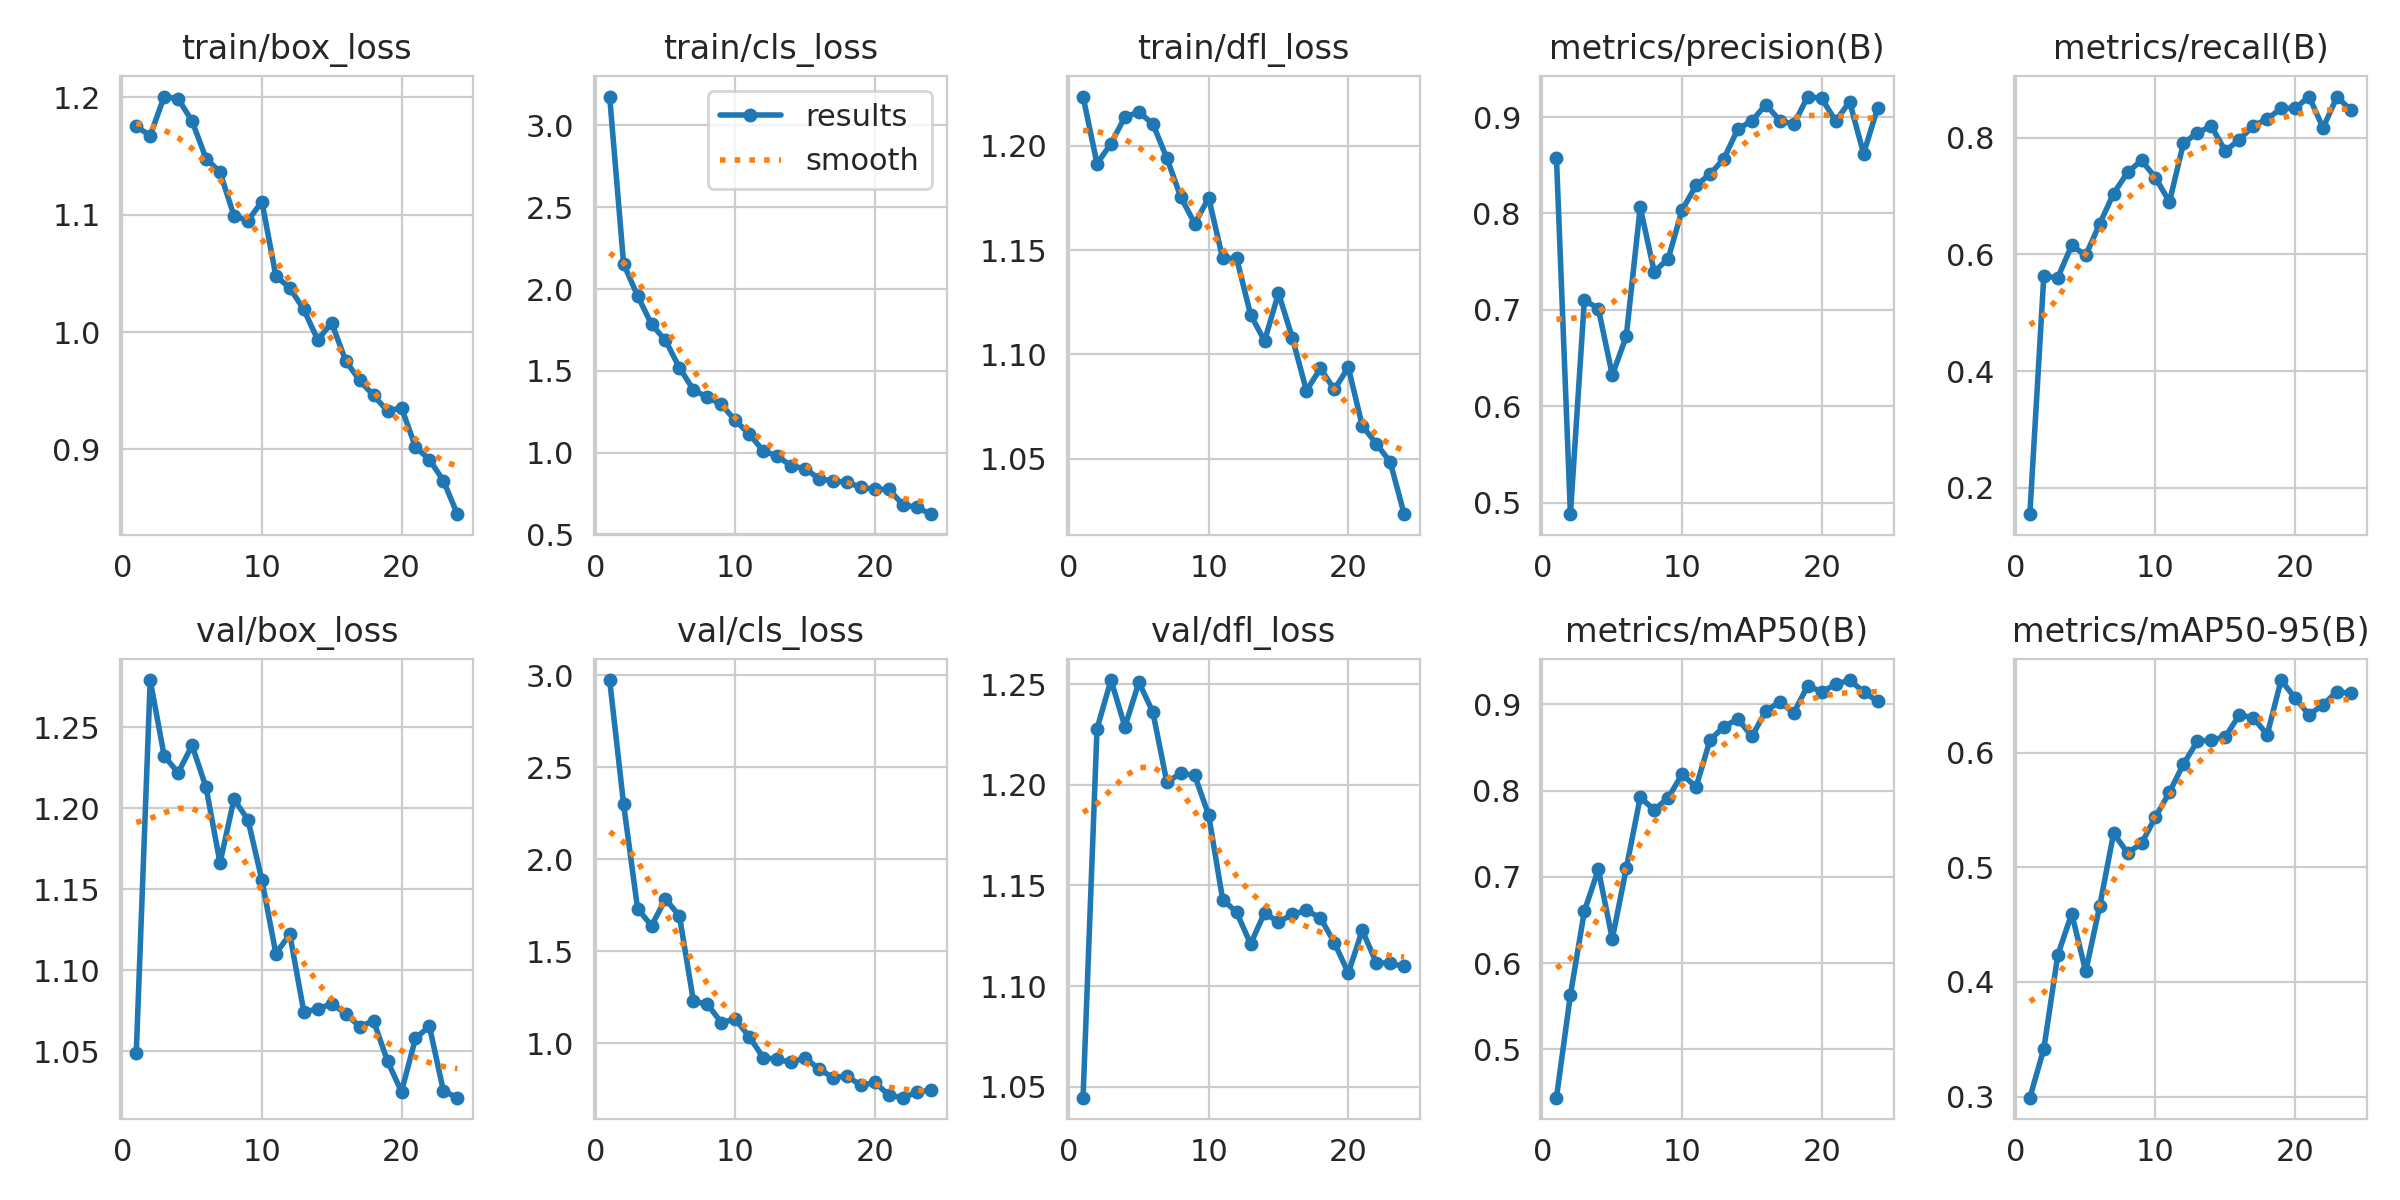

In [9]:
# Visualize training curves (loss, mAP, precision/recall) similar to the Gemini notebook summary
results_png = Path(model.trainer.save_dir) / "results.png"
if results_png.exists():
    display(Image(filename=str(results_png)))
else:
    print("results.png not found; verify training run path:", model.trainer.save_dir)


## 7. Evaluating the Model

- **mAP (mean Average Precision)**: area under the precision–recall curve across IoU thresholds and classes. Higher is better.
- **Precision**: of the predicted boxes, how many are correct (controls false positives).
- **Recall**: of the ground-truth boxes, how many did we find (controls false negatives).
- Visual inspection matters: numbers can look fine even if the model systematically confuses similar species. We'll inspect a few val images.

Ultralytics YOLOv8.1.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/wildlife_yolov8/data/wildlife_yolo/labels/val.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


                   all        240        269      0.921       0.85      0.922      0.668
      Virginia Opossum        240         38      0.963      0.947      0.991      0.801
                   Dog        240         39      0.884      0.872      0.862      0.631
         American Crow        240         74      0.971      0.905      0.973      0.692
               Chicken        240         34       0.93       0.78      0.884      0.595
          Domestic Cat        240         31      0.903       0.71      0.872      0.565
   American Black Bear        240         53      0.877      0.887      0.949      0.722
Speed: 0.3ms preprocess, 4.8ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bdb68b229c0>
curves: ['Precision-Recall

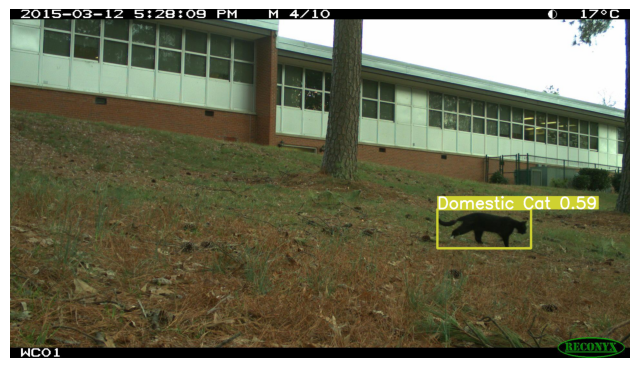

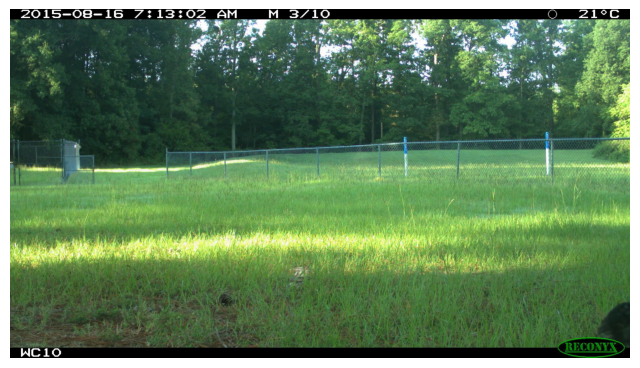

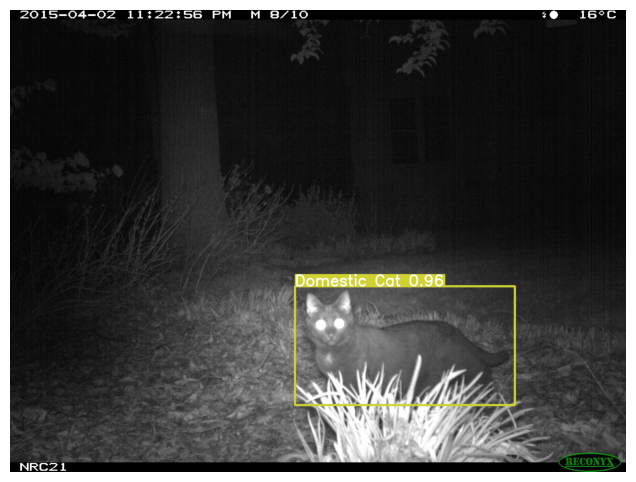

In [10]:
# Quantitative validation
best_weights = Path(model.trainer.save_dir) / 'weights' / 'best.pt'
if not best_weights.exists():
    raise FileNotFoundError('best.pt not found. Check training run or path.')
val_model = YOLO(best_weights)
val_results = val_model.val()
print(val_results)

# Visualize a handful of predictions on the val set
sample_paths = [entry['image_path'] for entry in random.sample(val_items, min(3, len(val_items)))]
if sample_paths:
    preds = val_model.predict(sample_paths, imgsz=640, conf=0.25)
    for res in preds:
        plotted = res.plot()  # BGR image with boxes drawn
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
else:
    print('No validation images available for visualization.')


## 8. Running Inference on Sample Images

We'll build a small helper that takes an image path, runs the model, and plots the detections. Try both a crowded scene and an empty frame to see false positives.

On an edge device, replace the file path with frames from a webcam or video stream; the rest (model call + thresholding) is the same.

Crowded example:

image 1/1 /content/wildlife_yolov8/data/processed/images/5650.jpg: 384x640 1 American Black Bear, 52.6ms
Speed: 3.4ms preprocess, 52.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


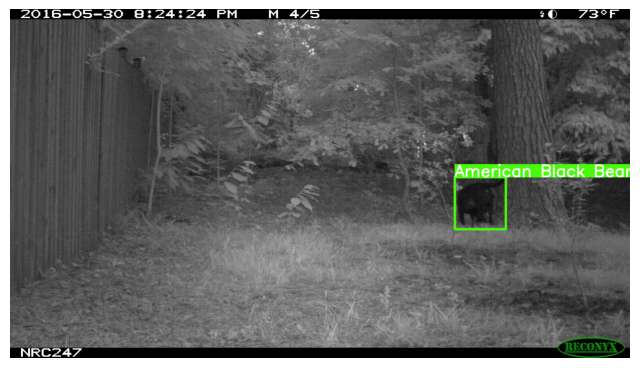

Potential empty/low-activity example:

image 1/1 /content/wildlife_yolov8/data/processed/images/8975.jpg: 480x640 1 American Black Bear, 43.8ms
Speed: 3.9ms preprocess, 43.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


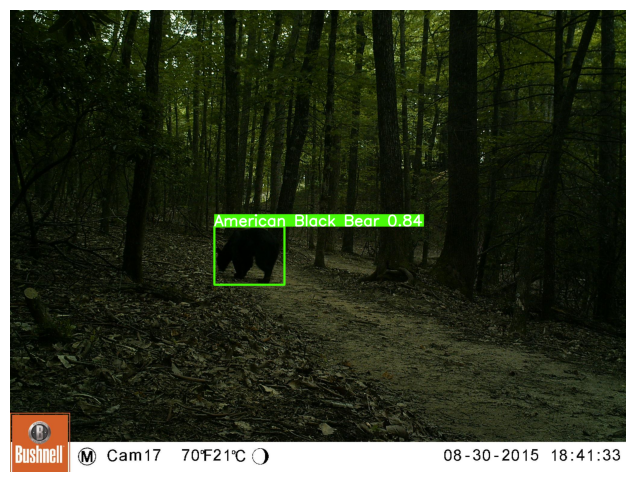

In [11]:
def run_inference(image_path, model, conf=0.25):
    """Run YOLO on one image and display results."""
    res = model.predict(image_path, imgsz=640, conf=conf)[0]
    plotted = res.plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(plotted, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return res

# Choose two examples (one possibly empty)
if len(val_items) >= 2:
    crowded = val_items[0]['image_path']
    maybe_empty = val_items[-1]['image_path']
    print("Crowded example:")
    _ = run_inference(crowded, val_model, conf=0.25)
    print("Potential empty/low-activity example:")
    _ = run_inference(maybe_empty, val_model, conf=0.10)
else:
    print("Not enough validation images to demo inference.")


## 9. Exporting the Model for Edge Deployment

- Find \`best.pt\` in the run folder.
- Export to **ONNX** (works in many runtimes, C++/Rust) and **TorchScript** (for PyTorch mobile/edge).
- Smaller models (\`yolov8n\`) or INT8 quantization are preferred on Raspberry Pi/Jetson. Use lower \`imgsz\` (e.g., 416) to trade detail for speed if needed.

In [15]:
# Export best weights to ONNX and TorchScript
# Install onnxscript if missing
import subprocess
try:
    import onnxscript
except ImportError:
    print("onnxscript not found. Installing...")
    subprocess.run("pip install -q onnxscript", shell=True, check=True)
    print("onnxscript installed.")

export_model = YOLO(best_weights)
onnx_path = export_model.export(format='onnx', imgsz=640, opset=18, dynamic=False, simplify=True)
ts_path = export_model.export(format='torchscript', imgsz=640)

print("Exported:")
print("  ONNX:", onnx_path)
print("  TorchScript:", ts_path)

print("Files in weights folder:")
for p in (Path(best_weights).parent).glob('*'):
    print(" -", p.name)


Ultralytics YOLOv8.1.34 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'wildlife_yolov8/ena24_yolov8n2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 10, 8400) (5.9 MB)

ONNX: starting export with onnx 1.19.1 opset 18...
Applied 1 of general pattern rewrite rules.
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 2.9s, saved as 'wildlife_yolov8/ena24_yolov8n2/weights/best.onnx' (11.6 MB)

Export complete (4.5s)
Results saved to /content/wildlife_yolov8/ena24_yolov8n2/weights
Predict:         yolo predict task=detect model=wildlife_yolov8/ena24_yolov8n2/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=wildlife_yolov8/ena24_yolov8n2/weights/best.onnx imgsz=640 data=/content/wildlife_yolov8/data/wildlife_yolo/wildlife.yaml  
Visualize:       https://netron.app
Ultralytics YOLOv8.1.34 🚀 Python-3.12.12 tor

## 10. Next Steps and Extensions

- Train on a larger mix (e.g., Caltech Camera Traps, Snapshot Serengeti, WCS) or your own camera data; merge datasets by harmonizing class names.
- Group rare species into broader buckets (e.g., "bird", "deer", "predator") to reduce class imbalance.
- Add **temporal cues**: run detection over short clips or consecutive frames to suppress false positives on empty frames.
- Experiment with **augmentation** (mixup, mosaic, random brightness) to improve low-light/night robustness.
- Deploy to edge: quantize the ONNX model (e.g., with ONNX Runtime or TensorRT), run inference in a loop, and trigger video recording or SMS alerts only when confidence crosses a threshold.
